In [84]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.optimize as opt
import scipy.interpolate as interp

import gc_turbulence as gct
from gc_turbulence import ProcessedRun

%matplotlib inline

In [5]:
index = 'r14_01_14a'
cache_path = '/home/aaron/lab/local/processed/' + index + '.hdf5'
cache_path = gct.default_processed + index + '.hdf5'

r = ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

x = r.X[0, :, 0]
z = r.Z[:, 0, 0]

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

In [74]:
L = 5.5
H = 0.25
g = 9.81

def full_frequency(n, scaling=1.006):
    k = np.pi * n / L
    w2 = g * k * np.tanh(k * H)
    return scaling * np.sqrt(w2) / (2 * np.pi)

def plot_all_frequencies(n, **kwargs):
    scaling = kwargs.pop('scaling', 1.008)
    for i in range(n):
        plt.axvline(full_frequency(i + 1, scaling), **kwargs)
        
def plot_smooth_fft(signal, **kwargs):
    window = kwargs.pop('window', 'hanning')
    window = sig.get_window(window, signal.size, fftbins=False)
    
    fft = np.fft.rfft(signal * window, signal.size * 20)
    freqs = np.fft.rfftfreq(signal.size * 20, d=0.01)
    power = np.abs(fft)
    
    plt.semilogx(freqs, power, **kwargs)

In [433]:
ffta = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) * sig.hanning(8000), msize, axis=-1)
ffta = np.fft.rfft(m_sub[:, :, 300:8300].mean(axis=0) * sig.hanning(8000), msize, axis=-1)

freqs = np.fft.rfftfreq(msize, d=0.01)

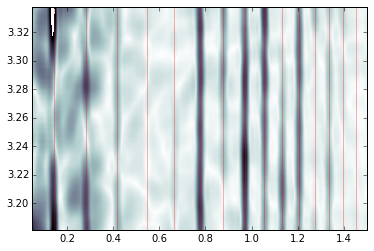

In [434]:
x = r.X[0, :, 0]
Ff, Xf = np.meshgrid(freqs, x)
plt.contourf(Ff, Xf, np.abs(ffta), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.05, 1.5)

plot_all_frequencies(20, alpha=0.3, color='r')

(0.5, 1.5)

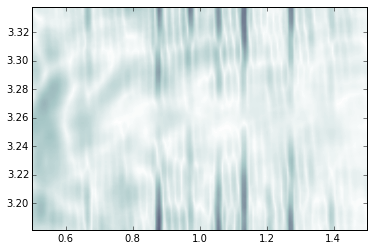

In [335]:
fftams = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) - r.U[:, :, :8000].mean(axis=0).mean(axis=0) * sig.boxcar(8000), msize, axis=-1)

plt.contourf(Ff, Xf, np.abs(fftams), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

(0.5, 3)

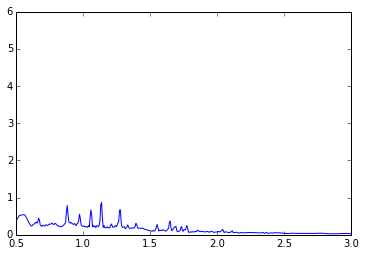

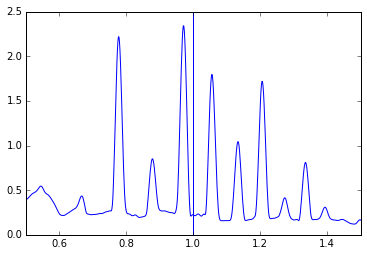

In [29]:
plt.plot(ffreqs, np.abs(ffta).mean(axis=0))

plt.xlim(0.5, 1.5)
plt.ylim(0, 2.5)

plt.axvline(full_frequency(8) + 0.03)

In [193]:
def find_nearest_idx(array,value):
    return (np.abs(array-value)).argmin()


def find_closest_peaks(power, freqs, guess_freqs):
    """Given a power spectrum over frequencies `freqs` 
    find the array indices of the power spectrum peaks 
    closest to the guess_freqs.
    """
    # find the maxima in the power spectrum
    maxima = sig.argrelextrema(power, np.greater)

    maxima_freqs = np.zeros(freqs.shape)
    maxima_freqs[maxima] = freqs[maxima]
    
    # determine the peaks as the closest maxima to each of the standing wave frequencies
    peak_indices = [find_nearest_idx(maxima_freqs, f) for f in guess_freqs]
    return peak_indices
    


def construct_wave(amplitude, f, length):
    return amplitude * np.exp(2j * np.pi * f * np.arange(length) * 0.01)

def subtract_amplitude(power, amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return power - np.abs(np.fft.rfft(wave, size))

def wave_fft(amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return np.fft.rfft(wave, size)

def subtract_amplitude_fft(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude, f, size, window)

    
def minimise_this(vector, fft, size, window):
    frequency = vector[0]
    phase = vector[1]
    amplitudes = vector[2:]
    
    amplitudes = amplitudes * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitudes[:, None], f, size, window))

In [54]:
f = full_frequency(8)
size = msize
window = sig.hamming(8000)

idx = np.abs(freqs - f).argmin()

phase = np.angle(ffta).mean(axis=0)[idx]
frequency = ffreqs[idx]

amplitudes = np.abs(fffta)[:, idx]

#wave_fft(amplitudes[:, None], frequency, size, window)
    
    # use phase, frequency and amplitudes as first guess
    # i.e. assume phase and frequency constant across x
    
    # minimise the power spectrum around this frequency (+- 0.03)
    
vector = np.hstack((frequency, phase, amplitudes))

fpbounds = [(frequency - 0.03, frequency + 0.03),
          (None, None)]

abounds = [(None, None) for _ in amplitudes]

bounds = fpbounds + abounds

print f
print frequency
print phase

0.967895683422
0.967407226562
-1.15300580588


In [41]:
minimise_this(vector, fffta, size, window)

2537.9805114880492

In [46]:
minim = opt.minimize(minimise_this, x0=vector, args=(fffta, size, window), bounds=bounds)
print minim

  status: 0
 success: True
    nfev: 1243
     fun: 2537.9686270456973
       x: array([ 0.96740723, -1.24716268,  2.24925533,  2.2410838 ,  2.23592522,
        2.26202111,  2.28541806,  2.30560022,  2.35366911,  2.39234914,
        2.42197171,  2.47343359,  2.50769231,  2.52521513,  2.5092256 ,
        2.5171599 ,  2.50947781,  2.51013834,  2.50037383,  2.4826698 ,
        2.46067713,  2.42856137,  2.41665976,  2.39710898,  2.40897821,
        2.40856057,  2.40881172,  2.41728331,  2.42192333,  2.40997249,
        2.40649593,  2.43056896,  2.45999734,  2.50557262,  2.54869303,
        2.60916753,  2.65504418,  2.70941032,  2.73484239,  2.75285431,
        2.7481371 ,  2.74639862,  2.69722149,  2.65436479,  2.6299292 ,
        2.58120452,  2.55516331,  2.55149856,  2.5330803 ,  2.50498324,
        2.49147557,  2.4704589 ,  2.45617916,  2.42294254,  2.40235182,
        2.38734616,  2.36674423,  2.35559389,  2.32411612,  2.29630612,
        2.24513855,  2.2280302 ,  2.19317553,  2.163599

In [47]:
frequency = minim.x[0]
phase = minim.x[1]
amplitudes = minim.x[2:]

amplitudes = amplitudes * np.exp(1j * phase)

mffta = subtract_amplitude_fft(ffta, amplitudes[:, None], frequency, size, window)

(0, 2.5)

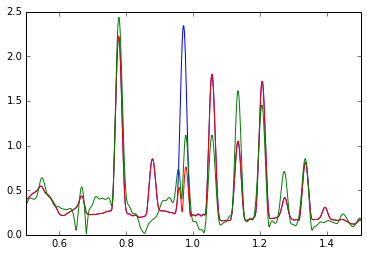

In [52]:
plt.plot(ffreqs, np.abs(ffta).mean(axis=0))
plt.plot(ffreqs, np.abs(mffta).mean(axis=0), 'r')
plt.plot(ffreqs, np.abs(mffta)[3])

plt.xlim(0.5, 1.5)
plt.ylim(0, 2.5)

In [57]:
fftx = np.fft.rfft(r.U[:, :, :8000].mean(axis=0), 1024, axis=0)

<matplotlib.contour.QuadContourSet instance at 0x2ac93c1bd320>

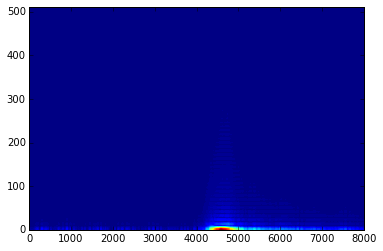

In [59]:
plt.contourf(np.abs(fftx), 100)

<matplotlib.contour.QuadContourSet instance at 0x2ac95a880908>

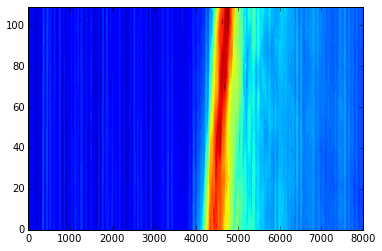

In [61]:
plt.contourf(r.U[:, :, :8000].mean(axis=0), 100)

In [63]:
import scipy.ndimage as ndi

dx = r.X[0, 1, 0] - r.X[0, 0, 0]
shear = 1 / (r.front_speed.value * r.dt / dx)

Aa = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, shear, 1]])

iAa = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, -shear, 1]])

tra = ndi.affine_transform(r.U[:, :, :], Aa, order=0, cval=np.nan)
mtra = tra.mean(axis=1, keepdims=1)
m_sub = ndi.affine_transform(tra - mtra, iAa, order=0, cval=np.nan)

In [65]:
fftx = np.fft.rfft(m_sub.mean(axis=0), 1024, axis=0)

<matplotlib.contour.QuadContourSet instance at 0x2ac95b01bb00>

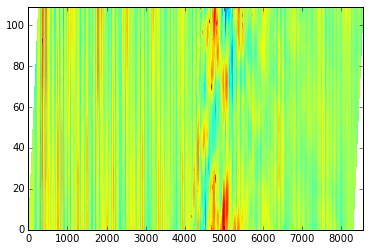

In [64]:
plt.contourf(m_sub.mean(axis=0), 100)

<matplotlib.contour.QuadContourSet instance at 0x2ac95eb4c950>

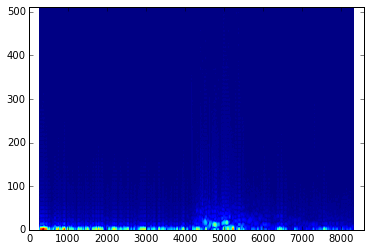

In [66]:
plt.contourf(np.abs(fftx), 100)

In [ ]:
plt.contourf(np.fft.irfft(fftx, axis=0), 100)

In [72]:
np.fft.irfft(fftx, axis=0).shape

(1024, 8576)

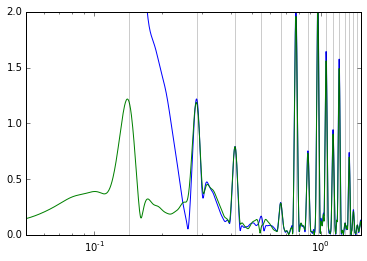

In [429]:
plot_smooth_fft(r.U[..., :8000].mean(axis=0).mean(axis=0))
plt.xlim(0.05, 1.5)
plt.ylim(0, 2)
plot_smooth_fft(m_sub[..., 300:8300].mean(axis=0).mean(axis=0))

plot_all_frequencies(20, alpha=0.2, color='k')

In [132]:
where = (freqs > 0.5) & (freqs < 1.5)

ifx = [interp.UnivariateSpline(freqs[where], np.abs(fx[where]), k=5) for fx in ffta]

(2.46, 2.505)

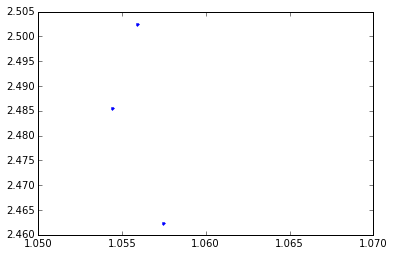

In [135]:
plt.plot(freqs[where], np.abs(fx[where]), '.')
plt.plot(freqs[where], ifx[-1](freqs[where]))

plt.xlim(1.05, 1.07)
plt.ylim(2.46, 2.505)

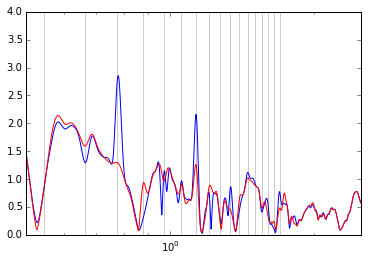

In [142]:
plot_smooth_fft(r.U[-20, 0, 300:8300])
plot_smooth_fft(r.U[-20, 0, 300:8300] - m_sub[10:, :, 300:8300].mean(axis=0).mean(axis=0), color='r')

plt.xlim(0.5, 2.5)
plt.ylim(0, 4)

plot_all_frequencies(20, color='k', alpha=0.2)

In [166]:
iamp = interp.RectBivariateSpline(x, freqs, np.abs(ffta))
iphase = interp.RectBivariateSpline(x, freqs, np.angle(ffta))

(0.5, 2)

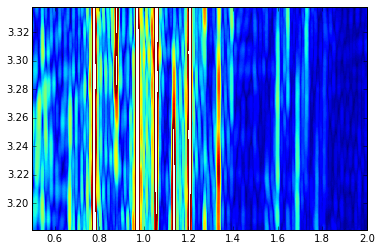

In [181]:
plt.contourf(Ff, Xf, iamp(x, freqs), levels=np.linspace(0, 2, 100))
plt.xlim(0.5, 2)

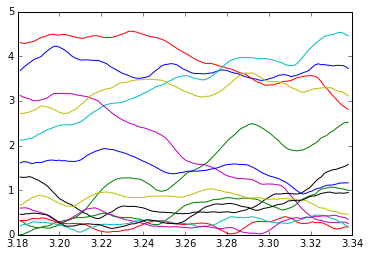

In [171]:
plt.plot(x, iamp(x, full_frequency(np.arange(6, 20))));

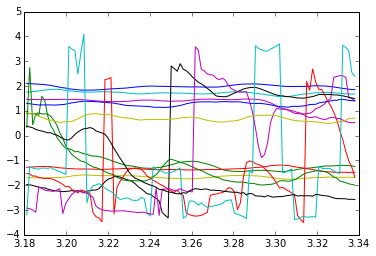

In [172]:
plt.plot(x, iphase(x, full_frequency(np.arange(6, 20))));

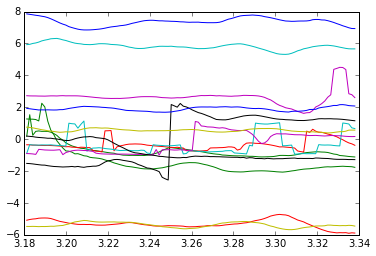

In [170]:
plt.plot(x,  iamp(x, full_frequency(np.arange(6, 20))).mean(axis=0) * iphase(x, full_frequency(np.arange(6, 20))));

In [ ]:
# get the phase, frequencies from peaks of fft(r.U.mean.mean)
# get amplitude from interpolated abs(fft) at found frequencies

# maybe do this with fftams

# this will do poorly on anything that averages to zero
# therefore determine phase, frequencies from peaks of abs(fft(r.U.mean)).mean - no, this is tricky for phase

# as a fallback, just subtract r.U.mean.mean and be done with it

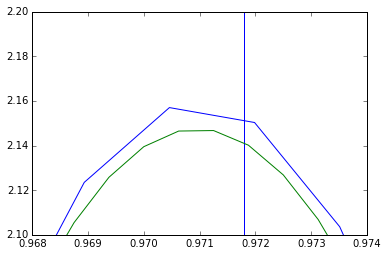

In [223]:
plt.plot(freqs, np.abs(ffta).mean(axis=0))

#plt.plot(freqs, np.abs(fftams).mean(axis=0))
plt.xlim(0.968, 0.974)
plt.ylim(2.1, 2.2)

plt.axvline(0.9718)

plot_smooth_fft(r.U[:, :, :8000].mean(axis=0).mean(axis=0))
plot_smooth_fft(r.U[:, 50:, :8000].mean(axis=0).mean(axis=0))

plt.xscale('linear')

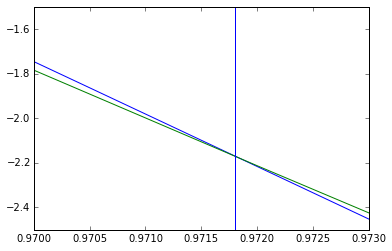

In [229]:
plt.plot(freqs, np.angle(ffta).mean(axis=0))
plt.plot(freqs, np.angle(np.fft.rfft(r.U[:, :, :8000].mean(axis=0).mean(axis=0) * sig.boxcar(8000), 65536)))
plt.xlim(0.97, 0.973)
plt.ylim(-2.5, -1.5)

plt.axvline(0.9718)
plot_all_frequencies(20, color='k')

In [ ]:
# create a 'comb' function that takes a graph like above
# and filters it t only create waves of (near) given frequencies

# like the minimisation routines from w-waves

# can we create a background by notching out the frequencies and interpolating?

# use just half the x info to avoid zeroing out

(0, 5)

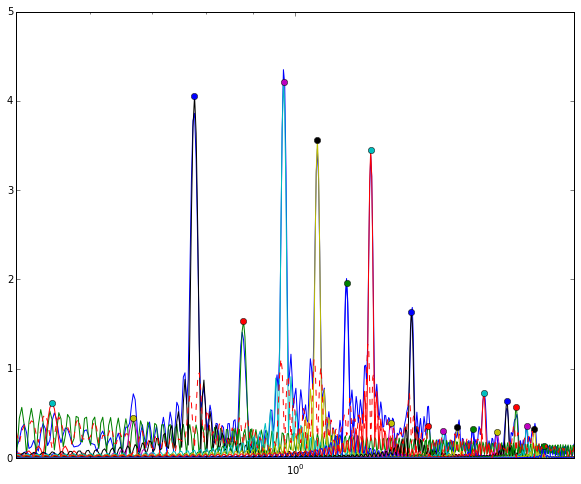

In [839]:
standing_frequencies = full_frequency(np.arange(30))

size = msize
window = sig.boxcar(8000)

ffta = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) * window, size, axis=-1)
freqs = np.fft.rfftfreq(size, d=0.01)


fftm = np.fft.rfft(r.U[:, :, 300:8300].mean(axis=0).mean(axis=0) * window, size, axis=-1)

sub_fft = fftm.copy()

def minimise_this_all((amplitude, f, phase), fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_all(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 2
        bounds = [(None, None), bounds, (None, None)]
    minim = opt.minimize(minimise_this_all, x0=(amplitude, freqs[peak], phase), args=(fft, size, window), bounds=bounds)
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, wave_fft(camplitude, opt_freq, size, window)

def minimise_this_phase((amplitude, phase), f, fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_phase(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    idx=peak
    
    amplitude = power[idx]
    phase = np.angle(fft[idx])
        
    # we can send either f, freqs[peak] or freqs[idx] into the minimiser.
    fmin = freqs[peak]
    minim = opt.minimize(minimise_this_phase, x0=(amplitude, phase), args=(fmin, fft, size, window))
    opt_amplitude = minim.x[0]
    opt_phase = minim.x[1]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, fmin, wave_fft(camplitude, fmin, size, window)

plt.figure(figsize=(10, 8))
plt.semilogx(freqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.float)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

#sorted_peaks = np.abs(fft[np.abs(standing_frequencies[:, None] - freqs).argmin(axis=1)]).argsort()[::-1]


for i, f in enumerate(standing_frequencies[:25]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, freqs, size, window, 
                                                                       bounds=(f-0.01,f+0.01))

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')

plt.xlim(0.5, 2)
plt.ylim(0, 5)

(0.5, 1.5)

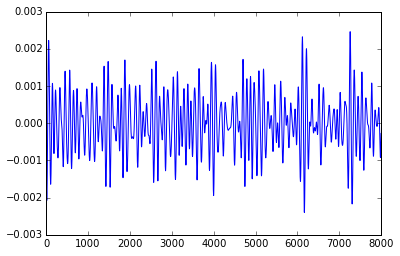

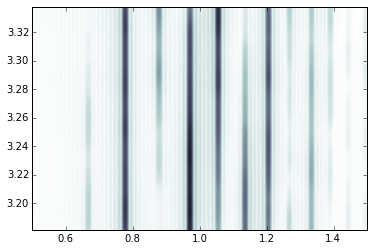

In [840]:
combed_amplitudes = iamp(x, frequencies[5:25])

full_amplitudes = combed_amplitudes * amplitudes[5:25] / np.abs(amplitudes[5:25])

combed_waves = (1 / window.sum()) * construct_wave(full_amplitudes[..., None], frequencies[5:25, None], 8000).sum(axis=1).real

plt.plot(combed_waves.mean(axis=0))
plt.figure()

fftc = np.fft.rfft(combed_waves, msize, axis=-1)
freqsm = np.fft.rfftfreq(msize, d=0.01)

Ff, Xf = np.meshgrid(freqsm, x)
plt.contourf(Ff, Xf, np.abs(fftc), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

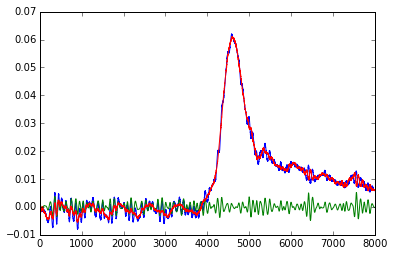

In [317]:
plt.plot(r.U[:, :, :8000].mean(axis=0).mean(axis=0))
plt.plot(combed_waves.mean(axis=0))
plt.plot(r.U[:, :, :8000].mean(axis=0).mean(axis=0) - combed_waves.mean(axis=0))


(0, 3)

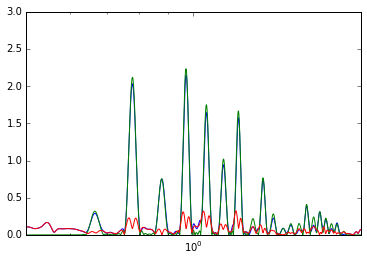

In [322]:
plot_smooth_fft(r.U[:, :, :8000].mean(axis=0).mean(axis=0))
plot_smooth_fft(combed_waves.mean(axis=0))
plot_smooth_fft(r.U[:, :, :8000].mean(axis=0).mean(axis=0) - combed_waves.mean(axis=0))
plt.xlim(0.5, 2)
plt.ylim(0, 3)

(0.5, 1.5)

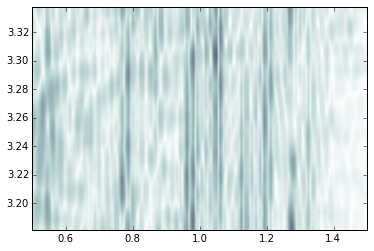

In [310]:
fftcm = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) - combed_waves, msize, axis=-1)
freqsm = np.fft.rfftfreq(msize, d=0.01)

Ff, Xf = np.meshgrid(freqsm, x)
plt.contourf(Ff, Xf, np.abs(fftcm), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

(0.5, 1.5)

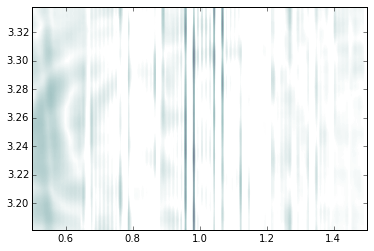

In [333]:
plt.contourf(Ff, Xf, np.abs(ffta) - np.abs(fftc), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

(0.5, 1.5)

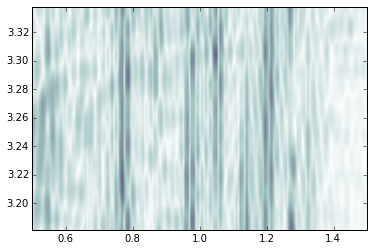

In [438]:
plt.contourf(Ff, Xf, np.abs(ffta - fftc), levels=np.linspace(0, 3, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

In [338]:
where = np.s_[:, (freqs > 0.5) & (freqs < 2)]

print np.linalg.norm(ffta[where]), ffta.shape
print np.linalg.norm(fftams[where]), fftams.shape
print np.linalg.norm(fftc[where]), fftc.shape
print np.linalg.norm(fftcm[where]), fftcm.shape

85.0174412181 (110, 8193)
50.6722974318 (110, 8193)
128.844769366 (110, 8193)
63.137487672 (110, 8001)


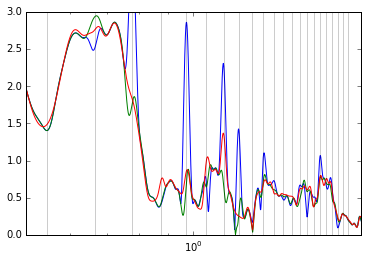

In [352]:
plot_smooth_fft((r.U[-30, 20, :8000]))
plot_smooth_fft((r.U[..., :8000] - combed_waves[None, ...])[-30, 20, :8000])
plot_smooth_fft((r.U[..., :8000] - r.U[..., :8000].mean(axis=0).mean(axis=0))[-30, 20, :8000])

plt.xlim(0.5, 2)
plt.ylim(0, 3)

plot_all_frequencies(25, alpha=0.2, color='k')

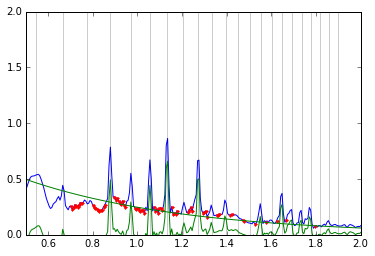

In [407]:
plt.plot(freqs, np.abs(fftams).mean(axis=0))
plt.xlim(0.5, 2)
plt.ylim(0, 2)


plot_all_frequencies(25, alpha=0.2, color='k')

d = 0.02
which = (freqs < standing_frequencies[:, None] + d) & (freqs > standing_frequencies[:, None] - d)

which = ~which.sum(axis=0).astype(np.bool) & (freqs > 0.7)

plt.plot(freqs[which], np.abs(fftams).mean(axis=0)[which], 'r.')
# can we detrend this and then use as the cost function?
freqs[which]

def trend(x, a):
    return np.exp(x * a)

popt, pcov = opt.curve_fit(trend, freqs[which], np.abs(fftams).mean(axis=0)[which])
plt.plot(freqs, trend(freqs, popt), 'g')

plt.plot(freqs, np.abs(fftams).mean(axis=0) - trend(freqs, popt))

(0.5, 2)

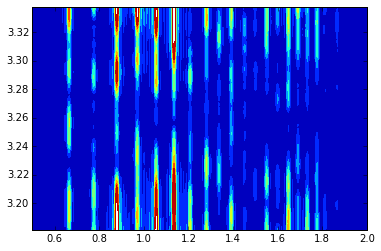

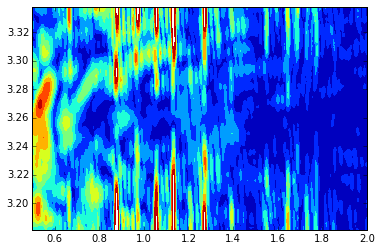

In [427]:
miamp = interp.RectBivariateSpline(x, freqs, np.abs(fftams))

mcombed_amplitudes = miamp(x, frequencies[5:25])

mfull_amplitudes = mcombed_amplitudes * np.exp(1j * np.angle(amplitudes[5: 25]))

mcombed_waves = (1 / window.sum()) * construct_wave(mfull_amplitudes[..., None], frequencies[5:25, None], 8000).sum(axis=1).real

plt.contourf(Ff, Xf, np.abs(np.fft.rfft(mcombed_waves, msize, axis=-1)), levels=np.linspace(0, 1, 10))
plt.xlim(0.5, 2)

plt.figure()
plt.contourf(Ff, Xf, np.abs(fftams), levels=np.linspace(0, 1, 10))
plt.xlim(0.5, 2)

(0, 1)

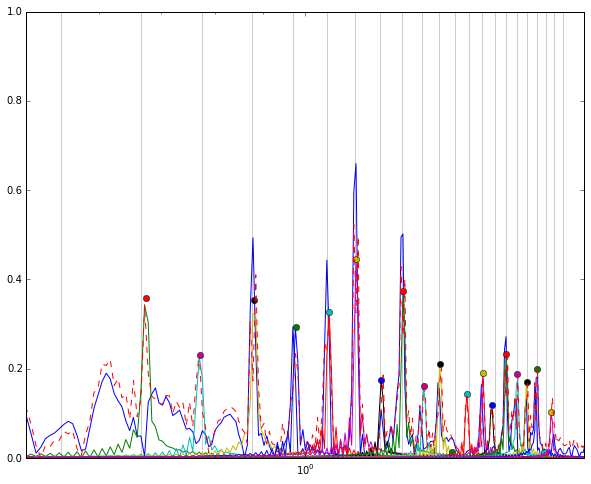

In [416]:
sub_fft = np.abs(fftams).mean(axis=0) - trend(freqs, popt)

def minimise_this_all((amplitude, f, phase), fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_all(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 2
        bounds = [(None, None), bounds, (None, None)]
    minim = opt.minimize(minimise_this_all, x0=(amplitude, freqs[peak], phase), args=(fft, size, window), bounds=bounds)
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, wave_fft(camplitude, opt_freq, size, window)

plt.figure(figsize=(10, 8))
plt.semilogx(freqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.float)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

plot_all_frequencies(25, alpha=0.2, color='k')

window = sig.boxcar(8000)

for i, f in enumerate(standing_frequencies[5:25]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, freqs, size, window, 
                                                                       bounds=(f-0.01,f+0.01))

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')

plt.xlim(0.5, 2)
plt.ylim(0, 1)

(0, 5)

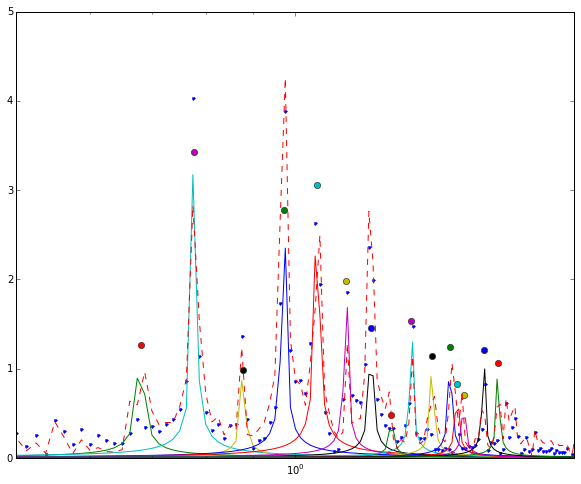

In [264]:
def minimise_barycentric(f, fft, freqs, size, window):
    power = np.abs(fft)
    m = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))[0]
    
    if power[m + 1] >= power[m - 1]:
        dm = power[m + 1] / (power[m + 1] + power[m])
    elif power[m + 1] < power[m - 1]:
        dm = -power[m - 1] / (power[m - 1] + power[m])
    
    fc = (m + dm) * 100 / size
    ac = 2 * np.pi * dm * power[m] / (size * np.sin(np.pi * dm))
    
    ac = power[m] * np.sin(np.pi * dm) / (np.pi * dm)
    
    ac = 2 * dm * power[m] / np.sin(np.pi * dm)


    pc = np.angle(fft)[m] - dm * np.pi
    
    Ac = ac + np.exp(1j * pc)

    return Ac, fc, wave_fft(Ac, fc, size, window)

standing_frequencies = full_frequency(np.arange(30))

size = 8000
window = sig.boxcar(8000)

ffta = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) * window, size, axis=-1)
freqs = np.fft.rfftfreq(size, d=0.01)


fftm = np.fft.rfft(r.U[:, :, :8000].mean(axis=0).mean(axis=0) * window, size, axis=-1)

sub_fft = fftm.copy()

plt.figure(figsize=(10, 8))
plt.semilogx(freqs, np.abs(sub_fft), '.')

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

for i, f in enumerate(standing_frequencies[5:20]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_barycentric(f, sub_fft, freqs, size, window) 
                                                                       

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')

plt.xlim(0.5, 2)
plt.ylim(0, 5)

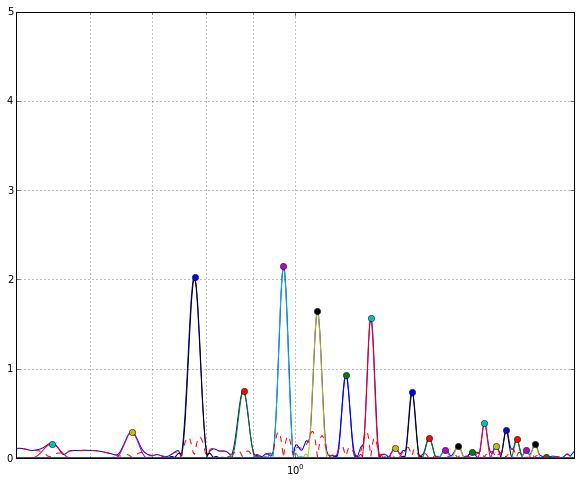

In [700]:
standing_frequencies = full_frequency(np.arange(30))

size = msize
window = sig.hanning(8000)

ffta = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) * window, size, axis=-1)
freqs = np.fft.rfftfreq(size, d=0.01)


fftm = np.fft.rfft(r.U[:, :, :8000].mean(axis=0).mean(axis=0) * window, size, axis=-1)

sub_fft = fftm.copy()

signal = r.U[:, :, :8000].mean(axis=0).mean(axis=0)

def minimise_this_var((amplitude, f, phase), signal, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return (bandpass(signal, f-0.02, f+0.02) - wave).var()

def minimise_power_var(f, signal, freqs, size, window, bounds=None):
    fft = np.fft.rfft(signal * window, size)
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 2
        bounds = [(None, None), bounds, (None, None)]
    minim = opt.minimize(minimise_this_all, x0=(amplitude, freqs[peak], phase), args=(fft, size, window), bounds=bounds)
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, wave_fft(camplitude, opt_freq, size, window)


plt.figure(figsize=(10, 8))
plt.semilogx(freqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.float)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

#sorted_peaks = np.abs(fft[np.abs(standing_frequencies[:, None] - freqs).argmin(axis=1)]).argsort()[::-1]


for i, f in enumerate(standing_frequencies[:25]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_var(f, signal, freqs, size, window, 
                                                                       bounds=(f-0.01,f+0.01))

    sub_fft = sub_fft - peak_ffts[i]
    
    wave = (2 / window.sum()) * construct_wave(amplitudes[i], frequencies[i], window.size)
    signal = signal - wave
    
    ffit = frequencies[i].real
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')

plt.xlim(0.5, 2)
plt.ylim(0, 5)
plt.grid(which='both')

In [828]:
ufft = fftpack.rfft(msm, axis=0)
udct1 = fftpack.dct(msm, axis=0, type=1)
udct2 = fftpack.dct(msm, axis=0, type=2)
udct3 = fftpack.dct(msm, axis=0, type=3)

(0, 10)

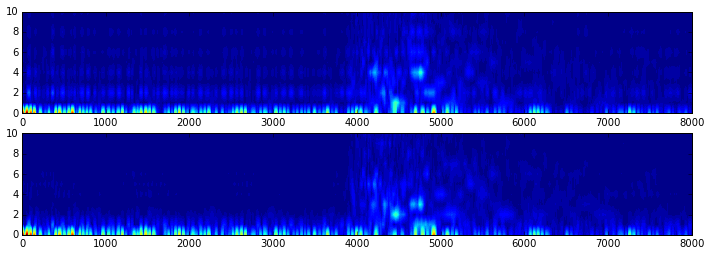

In [838]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 4))
ax[0].contourf(np.abs(ufft), 50)
ax[1].contourf(np.abs(udct2), 50)
ax[0].set_ylim(0, 10)
ax[1].set_ylim(0, 10)

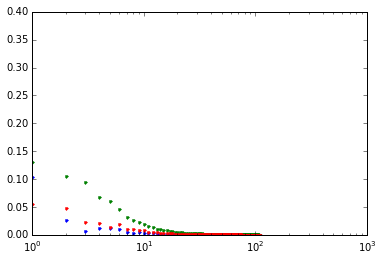

In [463]:
plt.semilogx(np.abs(udct)[:, 300:4000].mean(axis=1), '.')
plt.semilogx(np.abs(udct)[:, 4000:6000].mean(axis=1), '.')
plt.semilogx(np.abs(udct)[:, 6000:].mean(axis=1), '.')

<matplotlib.contour.QuadContourSet instance at 0x2acd6fd385a8>

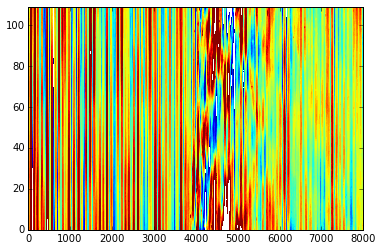

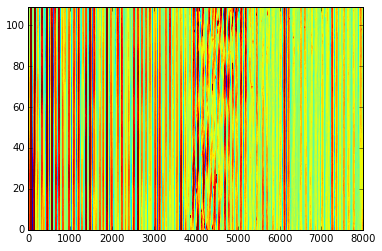

In [577]:
def bandpass(signal, cutoff, high_cutoff=False, axis=-1):
    fft = np.fft.rfft(signal, axis=axis)
    freqs = np.fft.rfftfreq(signal.shape[axis], d=0.01)
    
    s = [slice(None) for _ in range(signal.ndim)]
    s[axis] = freqs < cutoff
    rfft = fft.copy()
    rfft[s] = 0
    
    if high_cutoff:
        s[axis] = freqs > high_cutoff
        rfft[s] = 0
        
    rdata = np.fft.irfft(rfft, axis=axis)
    return rdata

lvl = np.linspace(-0.004, 0.004)
plt.contourf(m_sub[:, :, 300:8300].mean(axis=0), levels=lvl)

plt.figure()
plt.contourf(bandpass(m_sub[:, :, 300:8300].mean(axis=0), 0.7, axis=-1), levels=lvl)

In [703]:
mean_subtracted = m_sub[:, :, 300:8300]
msm = mean_subtracted.mean(axis=0)

In [1116]:
from scipy import fftpack

def mean_waves():
    signal = bandpass(msm, 0.7, axis=-1)
    return signal.mean(axis=0)

def fft_waves(index):
    signal = bandpass(msm, 0.7, axis=-1)
    fft = fftpack.rfft(signal, axis=0)
    fft[index:, :] = 0
    return fftpack.irfft(fft, axis=0)

def dct_waves(index, dct_type=2):
    signal = bandpass(msm, 0, axis=-1)
    udct = fftpack.dct(signal, axis=0, type=dct_type, norm='ortho')
    udct[index:, :] = 0
    return fftpack.idct(udct, type=dct_type, axis=0, norm='ortho')

def dst_waves(index, dst_type=2):
    signal = bandpass(msm, 0.7, axis=-1)
    udst = fftpack.dst(signal, axis=0, type=dst_type, norm='ortho')
    udst[index:, :] = 0
    return fftpack.idst(udst, type=dst_type, axis=0, norm='ortho')

import numpy.testing as npt

npt.assert_array_almost_equal(mean_waves(), fft_waves(1)[0], decimal=15)
npt.assert_array_almost_equal(mean_waves(), dct_waves(1)[0], decimal=15)

AssertionError: 
Arrays are not almost equal to 15 decimals

(mismatch 100.0%)
 x: array([-0.004338936103221, -0.004648343692485, -0.004535436966559, ...,
        0.000857938920514,  0.000610266605971,  0.000827005649206])
 y: array([ -4.954182117415422e-03,  -5.246599935079839e-03,
        -5.116193051534619e-03, ...,   1.950684069387614e-04,
        -3.731430724242753e-05,   1.953087380095230e-04])

In [893]:
window = sig.hanning(8000)
msize = 2 ** 15

ffta = np.fft.rfft(msm * window, msize, axis=-1)
fftb = np.fft.rfft(fft_waves(2) * window, msize, axis=-1)
fftd = np.fft.rfft(dct_waves(2) * window, msize, axis=-1)

fftr = np.fft.rfft((msm - fft_waves(2)) * window, msize, axis=-1)
fftrc = np.fft.rfft((msm - 2 * combed_waves) * window, msize, axis=-1)
fftrd = np.fft.rfft((msm - dct_waves(2)) * window, msize, axis=-1)

(0.05, 3)

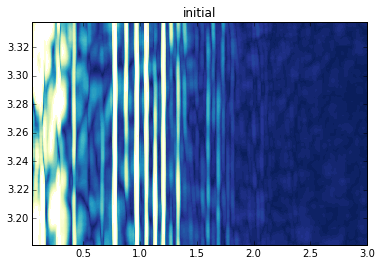

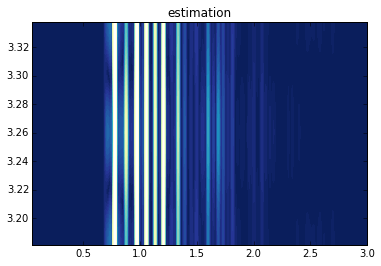

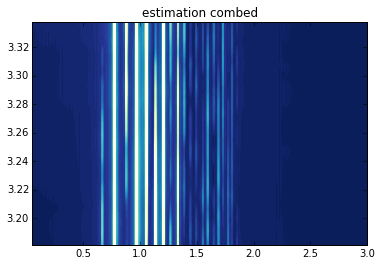

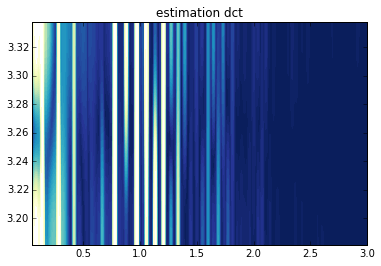

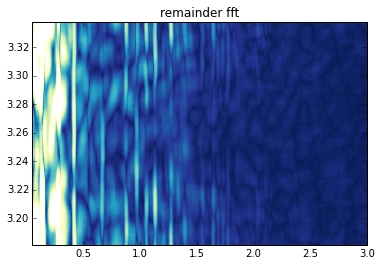

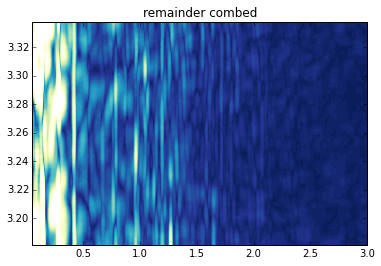

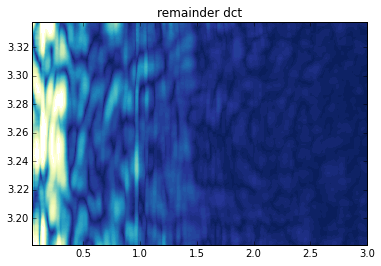

In [915]:
cmap = plt.cm.YlGnBu_r
lvl = np.linspace(0, 1, 50)
xlim = (0.05, 3)

x = r.X[0, :, 0]
freqs = np.fft.rfftfreq(msize, d=0.01)
Ff, Xf = np.meshgrid(freqs, x)

which = (freqs > xlim[0]) & (freqs < xlim[1])
F = Ff[:, which]
X = Xf[:, which]

plt.figure()
plt.title('initial')
plt.contourf(F, X, np.abs(ffta[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('estimation')
plt.contourf(F, X, np.abs(fftb[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('estimation combed')
plt.contourf(F, X, np.abs(fftc[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('estimation dct')
plt.contourf(F, X, np.abs(fftd[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('remainder fft')
plt.contourf(F, X, np.abs(fftr[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('remainder combed')
plt.contourf(F, X, np.abs(fftrc[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('remainder dct')
plt.contourf(F, X, np.abs(fftrd[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

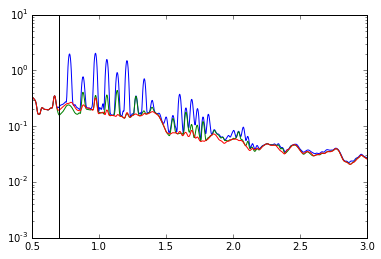

In [843]:
plt.plot(freqs, np.abs(ffta).mean(axis=0))
plt.plot(freqs, np.abs(fftr).mean(axis=0), color='g')
plt.plot(freqs, np.abs(fftrd).mean(axis=0), color='r')
plt.xlim(0.5, 3)
plt.axvline(0.7, color='k')
plt.yscale('log')

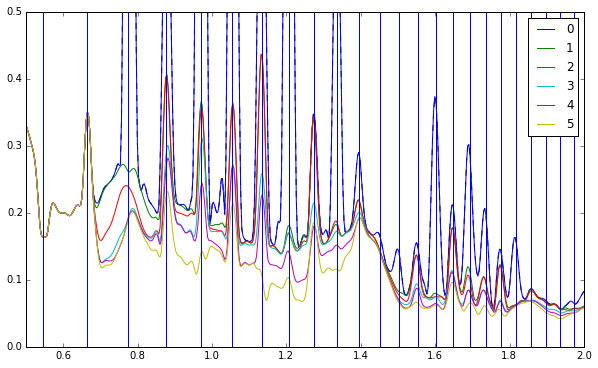

In [845]:
def compare(index, window=sig.hanning(8000)):
    fftr = np.fft.rfft((msm - fft_waves(index)) * window, msize, axis=-1)
    return np.abs(fftr).mean(axis=0)

plt.figure(figsize=(10, 6))

cwindow = sig.hanning(8000)

ffta = np.fft.rfft(msm * cwindow, msize, axis=-1)
plt.plot(freqs, np.abs(ffta).mean(axis=0), 'k--')

for index in range(6):
    plt.plot(freqs, compare(index, cwindow), label=str(index))
    
plt.xlim(0.5, 2.0)
plt.ylim(0, 0.5)
plt.legend()
plot_all_frequencies(80)

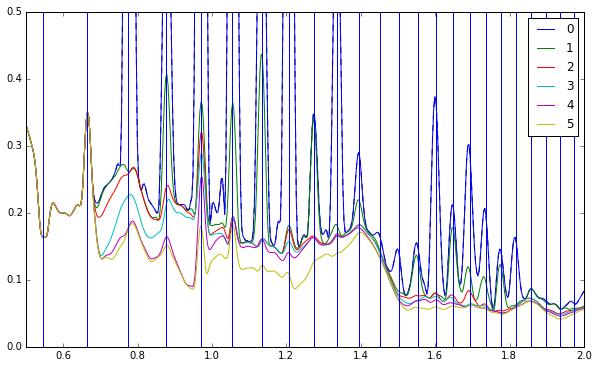

In [871]:
def compare_dct(index, window=sig.hanning(8000)):
    fftr = np.fft.rfft((msm - dct_waves(index)) * window, msize, axis=-1)
    return np.abs(fftr).mean(axis=0)

plt.figure(figsize=(10, 6))

cwindow = sig.hanning(8000)

ffta = np.fft.rfft(msm * cwindow, msize, axis=-1)
plt.plot(freqs, np.abs(ffta).mean(axis=0), 'k--')

for index in range(6):
    plt.plot(freqs, compare_dct(index, cwindow), label=str(index))
    
plt.xlim(0.5, 2.0)
plt.ylim(0, 0.5)
plt.legend()
plot_all_frequencies(80)

In [608]:
what = locals()

sizes = {local: what[local].nbytes / 1024 ** 2 for local in what if hasattr(what[local], 'nbytes') and type(getattr(what[local], 'nbytes')) is int}

for k in sorted(sizes, key=lambda s: sizes[s]):
    print k, sizes[k]

dx 3.81469726562e-06
upper 7.62939453125e-06
ffit 7.62939453125e-06
frequency 7.62939453125e-06
popt 7.62939453125e-06
shear 7.62939453125e-06
pcov 7.62939453125e-06
phase 7.62939453125e-06
idx 7.62939453125e-06
f 7.62939453125e-06
iAa 6.86645507812e-05
Aa 6.86645507812e-05
standing_frequencies 0.000228881835938
frequencies 0.000228881835938
lvl 0.000381469726562
z 0.000389099121094
x 0.000419616699219
amplitudes 0.000457763671875
u_levels 0.000762939453125
vector 0.0008544921875
which 0.0156259536743
mcombed_amplitudes 0.0167846679688
combed_amplitudes 0.0167846679688
mfull_amplitudes 0.0335693359375
full_amplitudes 0.0335693359375
window 0.06103515625
freqsm 0.0625076293945
wave 0.1220703125
signal 0.1220703125
freqs 0.125007629395
fftm 0.125015258789
sub_fft 0.125015258789
ffreqs 0.250007629395
fx 0.500015258789
F 0.688171386719
X 0.688171386719
zf 0.972747802734
tf 1.94549560547
mtra 3.3369140625
udct 3.35693359375
udct3 3.35693359375
udct2 3.35693359375
msm 3.35693359375
udct1 3.3

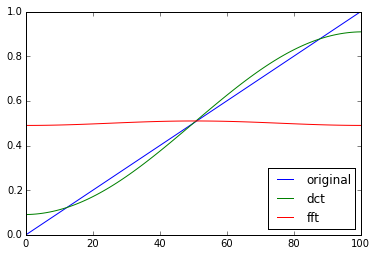

In [882]:
y = np.linspace(0, 1, 101)
dy = fftpack.dct(y, norm='ortho')
dy[2:] = 0

fy = fftpack.rfft(y)
fy[2:] = 0

plt.plot(y, label='original')
plt.plot(fftpack.idct(dy, norm='ortho'), label='dct')
plt.plot(fftpack.irfft(fy), label='fft')

plt.legend(loc='lower right')

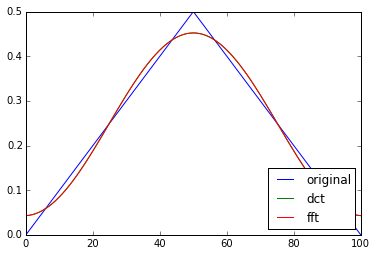

In [891]:
y = np.linspace(0, 1, 101)
y[51:] = y[49::-1]

dy = fftpack.dct(y, norm='ortho')
dy[3:] = 0

fy = fftpack.rfft(y)
fy[3:] = 0

plt.plot(y, label='original')
plt.plot(fftpack.idct(dy, norm='ortho'), label='dct')
plt.plot(fftpack.irfft(fy), label='fft')

plt.legend(loc='lower right')

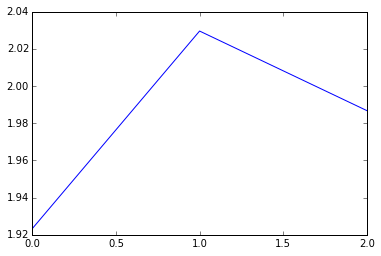

In [903]:
which = (freqs > 0.966) & (freqs < 0.975)
plt.plot(np.abs(ffta[:, which]).mean(axis=0))

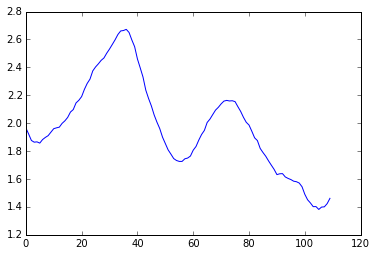

In [904]:
plt.plot(np.abs(ffta[:, which]).mean(axis=1))

In [ ]:
def contour_fft(signal, axis=-1, size=2**15, window='hanning', xlim=(0.05, 0.7)):
    window = sig.get_window(window, signal.shape[axis], fftbins=False)
    
    fft = np.fft.rfft(signal * window, size, axis=axis)
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    cmap = plt.cm.YlGnBu_r
    lvl = np.linspace(0, 1, 50)
    x = r.X[0, :, 0]
    Ff, Xf = np.meshgrid(freqs, x)

    which = (freqs > xlim[0]) & (freqs < xlim[1])
    F = Ff[:, which]
    X = Xf[:, which]
    
    plt.contourf(F, X, np.abs(fft)[:, which], levels=lvl, cmap=cmap)

<matplotlib.colorbar.Colorbar instance at 0x2ad0d82b5e18>

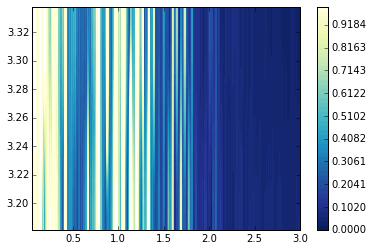

In [947]:
# here's another procedure, where we try to find the waves by looking
# at the dct of |fft(data)| rather than data, using the phase field of fft(data)
# unchanged. Doesn't seem to work so well - subtracts way too much information out.

ffta = np.fft.rfft(msm, msize, axis=-1)
dft = fftpack.dct(np.abs(ffta), axis=0, norm='ortho')
dft[2:] = 0

dft_waves = fftpack.idct(dft, axis=0, norm='ortho') * np.exp(1j * np.angle(ffta))

plt.contourf(F, X, (np.abs(dft_waves))[:, which], levels=lvl, cmap=cmap)
plt.colorbar()

<matplotlib.contour.QuadContourSet instance at 0x2ad0c66bd368>

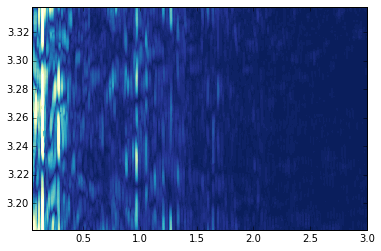

In [955]:
fftdft = np.fft.rfft(msm - np.fft.irfft(dft_waves, axis=-1)[:, :8000], msize, axis=-1)
plt.contourf(F, X, np.abs(fftdft)[:, which], levels=lvl, cmap=cmap)

(0.1, 3)

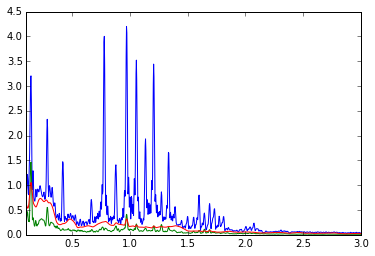

In [959]:
plt.plot(freqs, np.abs(ffta).mean(axis=0))
plt.plot(freqs, np.abs(fftdft).mean(axis=0))
plt.plot(freqs, np.abs(fftrd).mean(axis=0))
plt.xlim(0.1, 3)

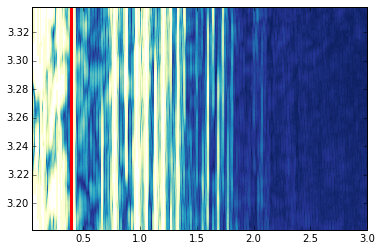

In [974]:
# calculate the frequency below which we expect periodic features to not be averaged out by mean subtraction.

c = r.front_speed.value
f_crit = c / (x.max() - x.min())

plt.figure()
plt.contourf(F, X, np.abs(ffta[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)
plt.axvline(f_crit, color='r', linewidth=3)

(0.05, 1.5)

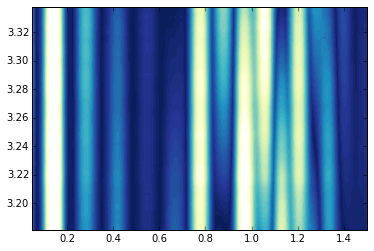

In [998]:
presignal = r.U[:, :, 300:3300].mean(axis=0)
prefft_box = np.fft.rfft(presignal * sig.boxcar(3000), axis=-1, n=msize)
prefft_han = np.fft.rfft(presignal * sig.hanning(3000), axis=-1, n=msize)
prefft_ratio = sig.boxcar(3000).sum() / sig.hanning(3000).sum()

plt.contourf(F, X, np.abs(prefft_han[:, which]), levels=lvl, cmap=cmap)
plt.xlim(0.05, 1.5)

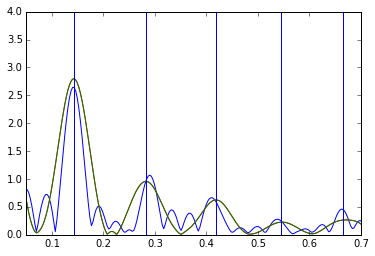

In [1053]:
# this demonstrates why we need to use windowing.
# The peaks of the boxcar windowed fft are off from the true peak location
# because of the side lobes from the adjacent frequency. Using the hanning
# window gives us the true peak location

plt.plot(freqs, np.abs(prefft_box).mean(axis=0))
plt.plot(freqs, np.abs(prefft_han).mean(axis=0) * prefft_ratio, color='r')
prefft_han_mean = np.fft.rfft(presignal.mean(axis=0) * sig.hanning(3000), axis=-1, n=msize)

plt.plot(freqs, np.abs(prefft_han_mean) * prefft_ratio)


plt.xlim(0.05, 0.7)
plot_all_frequencies(10)

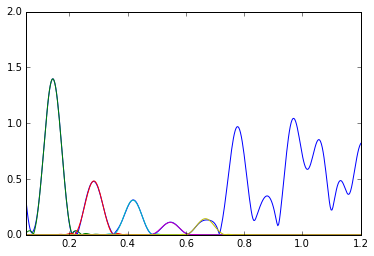

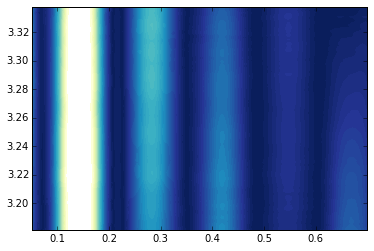

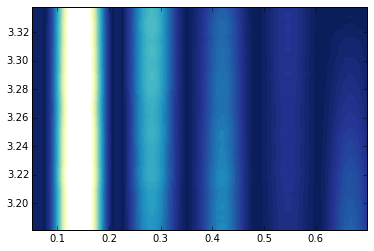

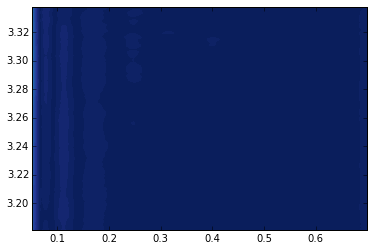

In [1107]:
def comb_frequencies(fft, nf, window, size, df=0.01, plots=False):
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    amplitudes = np.zeros(nf, np.complex)
    frequencies = np.zeros(nf, np.float)
    peak_ffts = np.zeros((nf, freqs.size), np.complex)
    
    if plots:
        plt.plot(freqs, np.abs(fft))
    # go through each guess frequency and find the nearest wave 
    # amplitude (complex) and frequency that would minimise the 
    # power spectrum, subtracting the optimal wave each time.
    for i, f in enumerate(full_frequency(np.arange(1, nf + 1))):
        amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, fft, freqs, size, window, 
                                                                         bounds=(f-df,f+df))
        fft = fft - peak_ffts[i]
        
        if plots:
            plt.plot(freqs, np.abs(peak_ffts[i]))
            plt.xlim(0.05, 1.2)
        
    return amplitudes, frequencies, peak_ffts


def extract_waves(data, nf, size=2**15, window='hanning', plots=False):
    x = r.X[0, :, 0]
    freqs = np.fft.rfftfreq(size, d=0.01)
    window = sig.get_window(window, data.shape[-1], fftbins=False)
    
    fft = np.fft.rfft(data * window, n=size, axis=-1)
    
    iamp = interp.RectBivariateSpline(x, freqs, np.abs(fft))
    iphase = interp.RectBivariateSpline(x, freqs, np.angle(fft))
    
    amplitudes, frequencies, peak_ffts = comb_frequencies(fft.mean(axis=0), nf=nf, window=window, size=size, plots=plots)

    combed_amplitudes = iamp(x, frequencies[:nf])
    full_amplitudes = combed_amplitudes * amplitudes[:nf] / np.abs(amplitudes[:nf])

    return (2 / window.sum()) * construct_wave(full_amplitudes[..., None], frequencies[:nf, None], 8000).sum(axis=1).real

pre_combed_waves = extract_waves(data=r.U[:, :, 300:3300].mean(axis=0), nf=5, window='hanning', plots=True)

plt.figure()
contour_fft(presignal)

plt.figure()
contour_fft(pre_combed_waves[:, :3000])

plt.figure()
contour_fft(presignal - pre_combed_waves[:, :3000])

In [1108]:
fftrp = np.fft.rfft(r.U[:, :, 300:8300].mean(axis=0) - pre_combed_waves, axis=-1, n=msize)
fftaa = np.fft.rfft(r.U[:, :, 300:8300].mean(axis=0), n=msize, axis=-1)

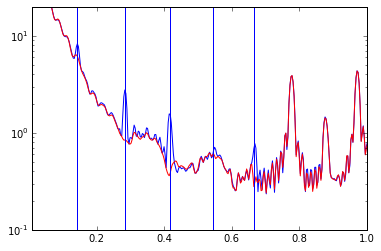

In [1109]:
plt.plot(freqs, np.abs(fftaa).mean(axis=0))
plt.plot(freqs, np.abs(fftrp).mean(axis=0), 'r')
plt.xlim(0.01, 1)
plt.ylim(0.1, 20)
plt.yscale('log')

plot_all_frequencies(5)

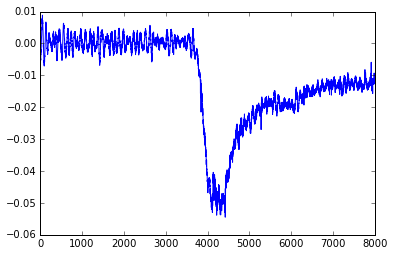

In [1110]:
plt.plot((r.U[:, :, 300:8300] - pre_combed_waves)[-1, 0])

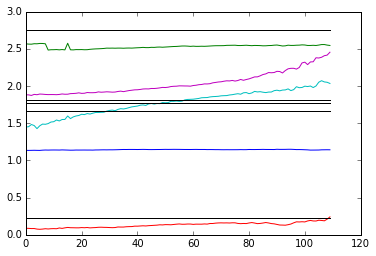

In [1066]:
plt.plot(np.abs(prefft_phase(x, frequencies[:nf])))
plt.plot(np.abs(np.angle(pre_full_amplitudes)), 'k')